<h1>Zadanie 8</h1>

<h2>CYFROWE PRZETWARZANIE SYGNAŁÓW I OBRAZÓW <br>
Przetwarzanie i analiza sygnału EKG</h2>
<h3>
Kasper Radom 264023 <br>
Maciej Szymczak 263978</h3>

In [1]:
%matplotlib ipympl
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from skimage import filters
from skimage.morphology import disk
from skimage.filters import rank, laplace, sobel, gaussian
from skimage.exposure import rescale_intensity
from IPython.display import display
from matplotlib.widgets import RectangleSelector

image_name = 'hidden-symbols.tif'
image = ski.io.imread(image_name)

Lokalne wyrównywanie histogramu

In [2]:
def local_histogram_equalization(image, mask_size):
    # Stwórz strukturujący element (maskę)
    selem = disk(mask_size)
    # Zastosuj lokalne wyrównywanie histogramu
    equalized_image = rank.equalize(image, selem)
    return equalized_image

Poprawa jakości oparta na lokalnych statystykach

In [3]:
def local_statistical_enhancement(image, mask_size, C, k0, k1, k2, k3):
    selem = disk(mask_size)

    # Oblicz lokalne średnie i odchylenie standardowe
    local_mean = rank.mean(image, selem).astype('float') / 255.0
    local_mean_sq = rank.mean(image ** 2, selem).astype('float') / 255.0
    local_var = np.clip(local_mean_sq - local_mean ** 2, 0, None)
    # local_stddev = np.std(image, selem=selem).astype('float')
    local_stddev = np.sqrt(local_var)

    global_mean = np.mean(image)
    global_stddev = np.std(image)

    # Przekształć obraz według lokalnych statystyk

    enhanced_image = np.zeros_like(image, dtype='float')
    mask1 = (local_mean <= k0 * global_mean) & (local_stddev <= k1 * global_stddev)
    mask2 = (local_stddev > k2 * global_stddev)
    mask3 = (local_stddev <= k3 * global_stddev)

    enhanced_image[mask1] = C * np.log1p(image[mask1])
    enhanced_image[mask2 & ~mask1] = C * np.sqrt(image[mask2 & ~mask1])
    enhanced_image[mask3 & ~mask1 & ~mask2] = image[mask3 & ~mask1 & ~mask2]

    # Normalizacja obrazu do zakresu 0-255
    enhanced_image = ski.exposure.rescale_intensity(enhanced_image, in_range=(0, np.max(enhanced_image)))

    return enhanced_image

Eksperymenty z różnymi rozmiarami masek

In [4]:
mask_sizes = [5, 15, 30]
C, k0, k1, k2, k3 = 22.8, 0, 0.1, 0, 0.1

Ustawienie liczby kolumn i wierszy dla subplotów

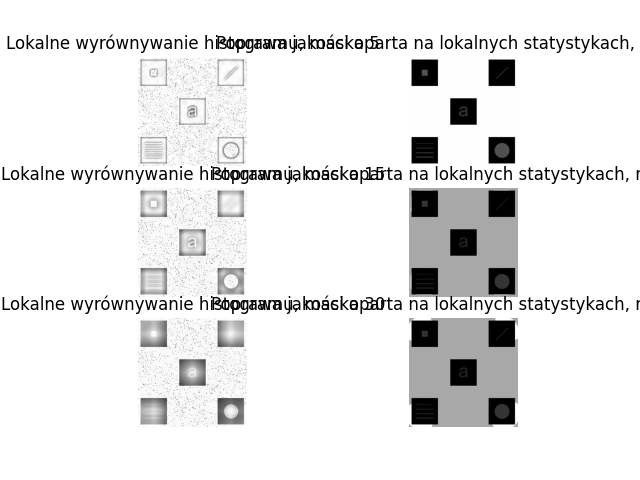

In [5]:
rows = len(mask_sizes)
cols = 2  # Dla lokalnego wyrównywania histogramu i poprawy jakości

for i, mask_size in enumerate (mask_sizes, 1):
    # Lokalne wyrównywanie histogramu
    equalized_image = local_histogram_equalization(image, mask_size)
    plt.subplot(rows, cols, i * 2 - 1)
    plt.imshow(equalized_image, cmap='gray')
    plt.title(f'Lokalne wyrównywanie histogramu, maska {mask_size}')
    plt.axis('off')

    # Poprawa jakości oparta na lokalnych statystykach
    enhanced_image = local_statistical_enhancement(image, mask_size, C, k0, k1, k2, k3)
    plt.subplot(rows, cols, i * 2)
    plt.imshow(enhanced_image, cmap='gray')
    plt.title(f'Poprawa jakości oparta na lokalnych statystykach, maska {mask_size}')
    plt.axis('off')
    
plt.show()